In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
import shutil

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models, transforms

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [ ]:
configs_default = dict(
    epochs = 10,
    learning_rate = 1e-4,
    weight_decay = 1e-2,
    batch_size = 50
)

if torch.cuda.is_available():
    configs_default['device'] = torch.device('cuda')
elif torch.backends.mps.is_available():
    configs_default['device'] = torch.device('mps')
else:
    configs_default['device'] = torch.device('cpu')

print(f"Using device: {configs_default['device']}")

Using device: mps


## Segmentando Imagens

In [346]:
path_raw = "../data/animals_class/raw"
folder_raw = os.listdir(path_raw)

# Verificando a quantidade de imagens por label
qtd_labels = {
   pasta: len(os.listdir(os.path.join(path_raw, pasta))) for pasta in folder_raw
}
qtd_labels

{'cat': 1458, 'dog': 1458, 'otter': 1458}

In [347]:
# Criando pasta de treino e teste

processed_folder = "../data/animals_class/processed"

dir_train = os.path.join(processed_folder, "train")
dir_test = os.path.join(processed_folder, "test")

if not os.path.exists(dir_train): os.makedirs(dir_train)
if not os.path.exists(dir_test): os.makedirs(dir_test)

In [348]:
for classes in folder_raw:
    dir_train_class = os.path.join(dir_train, classes)
    dir_test_class = os.path.join(dir_test, classes)

    if not os.path.exists(dir_train_class): os.makedirs(dir_train_class)
    if not os.path.exists(dir_test_class): os.makedirs(dir_test_class)

    dir_class = os.path.join(path_raw, classes)
    files = os.listdir(dir_class)

    train, test = train_test_split(files, test_size=0.2, random_state=42)

    print(f"Classe: {classes} - Train: {len(train)} - Test: {len(test)}")

    for file in train:
        origin = os.path.join(dir_class, file)
        destiny = os.path.join(dir_train_class, file)
        if not os.path.exists(destiny): shutil.copy(origin, destiny)

    for file in test:
        origin = os.path.join(dir_class, file)
        destiny = os.path.join(dir_test_class, file)

        if not os.path.exists(destiny): shutil.copy(origin, destiny)

Classe: cat - Train: 1166 - Test: 292
Classe: dog - Train: 1166 - Test: 292
Classe: otter - Train: 1166 - Test: 292


## Pré-processamento das Imagens
Vamos importar algumas imagens e fazer o tratamento necessário para que possamos utilizá-las em uma rede convolucional.

In [361]:
image_size = 224

In [362]:
image_transform = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ]),
}

In [363]:
dataset = {
    'train': datasets.ImageFolder(dir_train, transform=image_transform['train']),
    'test': datasets.ImageFolder(dir_test, transform=image_transform['test'])
}

print(dataset)

{'train': Dataset ImageFolder
    Number of datapoints: 3495
    Root location: ../data/animals_class/processed/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ), 'test': Dataset ImageFolder
    Number of datapoints: 876
    Root location: ../data/animals_class/processed/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )}


In [364]:
# Mapeando Indice para Label e salvando tamanho dos datasets de treino e teste
label_map = {index: class_name for class_name, index in dataset['train'].class_to_idx.items()}
configs_default['label_map'] = label_map
configs_default['num_class'] = len(label_map)
configs_default['len_train'] = len(dataset['train'])
configs_default['len_test'] = len(dataset['test'])

print(f"Label Map: {configs_default['label_map']}")
print(f"Num Classes: {configs_default['num_class']}")
print(f"Train Size: {configs_default['len_train']}")
print(f"Test Size: {configs_default['len_test']}")

Label Map: {0: 'cat', 1: 'dog', 2: 'otter'}
Num Classes: 3
Train Size: 3495
Test Size: 876


In [365]:
# Criando dataloaders
dataloader_train = DataLoader(dataset['train'], batch_size=configs_default['batch_size'], shuffle=True)
dataloader_test = DataLoader(dataset['test'], batch_size=configs_default['batch_size'], shuffle=True)

print(f"Train Dataloader: {len(dataloader_train)}")
print(f"Test Dataloader: {len(dataloader_test)}")

Train Dataloader: 70
Test Dataloader: 18


Vamos visualizar algumas imagens do dataset

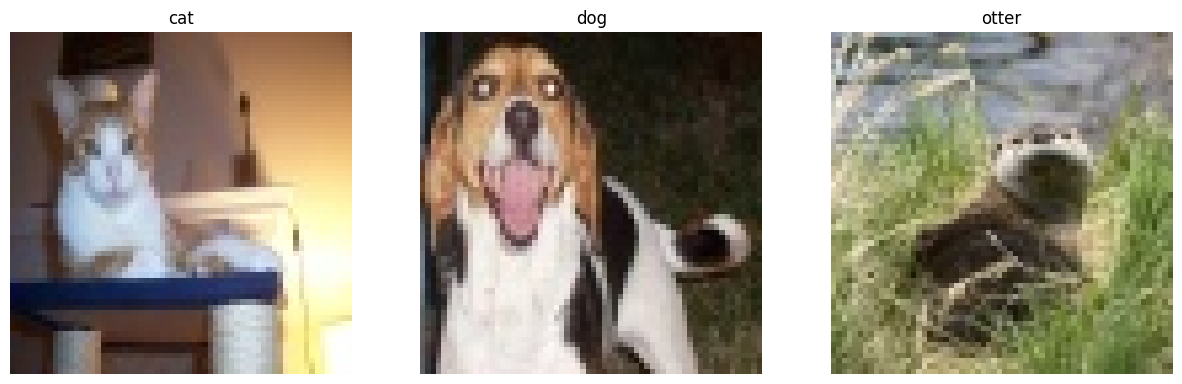

In [366]:
fig, ax = plt.subplots(1, configs_default['num_class'], figsize=(15, 5))
for indice, classe in label_map.items():
    dir_class = os.path.join(dir_train, classe)
    files = os.listdir(dir_class)[42]
    img = cv2.imread(os.path.join(dir_class, files))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax[indice].imshow(img)
    ax[indice].set_title(classe)
    ax[indice].axis('off')


## Treinando um modelo sem pré-treinamento

In [355]:
def train(train_loader, model):

    model.train()

    epoch_loss = []
    predict_list, target_list = np.array([]), np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(configs_default['device']), target.to(configs_default['device'])
        
        output = model(data)
        loss = loss_fn(output, target)

        #metrics
        epoch_loss.append(loss.item())
        _, predict = torch.max(output, 1)
        predict_list = np.concatenate((predict_list, predict.cpu().numpy()))
        target_list = np.concatenate((target_list, target.cpu().numpy()))

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    acc = metrics.accuracy_score(predict_list, target_list)
    
    print(f"TRAIN - Loss: {np.mean(epoch_loss)} - Acc: {acc}")

    return epoch_loss, acc

def validate(test_loader, model):

    model.eval()

    epoch_loss = []
    predict_list, target_list = np.array([]), np.array([])
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(configs_default['device']), target.to(configs_default['device'])
            
            output = model(data)
            loss = loss_fn(output, target)

            #metrics
            epoch_loss.append(loss.item())
            _, predict = torch.max(output, 1)
            predict_list = np.concatenate((predict_list, predict.cpu().numpy()))
            target_list = np.concatenate((target_list, target.cpu().numpy()))

    acc = metrics.accuracy_score(predict_list, target_list)
    
    print(f"VALIDATE - Loss: {np.mean(epoch_loss)} - Acc: {acc}")

    return epoch_loss, acc

def fit(train_loader, test_loader, model, epochs):
    epoch_loss_train = []
    epoch_loss_test = []
    epoch_acc_train = []
    epoch_acc_test = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} -------------------------------")
        train_loss, train_acc = train(train_loader, model)
        test_loss, test_acc = validate(test_loader, model)
        
        epoch_loss_train.append(np.mean(train_loss[0]))
        epoch_loss_test.append(np.mean(test_loss[0]))
        epoch_acc_train.append(train_acc)
        epoch_acc_test.append(test_acc)

        print("\n")

    print(f"Final Loss Train: {epoch_loss_train[-1]} - Final Loss Test: {epoch_loss_test[-1]}")
    print(f"Final Acc Train: {epoch_acc_train[-1]} - Final Acc Test: {epoch_acc_test[-1]}")

    predict(model, test_loader)

    plot_metrics(epoch_loss_train, epoch_loss_test, epoch_acc_train, epoch_acc_test)

def plot_metrics(train_loss, test_loss, train_acc, test_acc):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_loss, label='Train')
    ax[0].plot(test_loss, label='Test')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='Train')
    ax[1].plot(test_acc, label='Test')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()
    
def predict(model, data_loader):

    model.to(configs_default['device'])
    model.eval()
    
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(configs_default['device'])
            labels = labels.to(configs_default['device'])
            output = model(data)
            _, predict = torch.max(output, 1)
            all_predictions.append(predict.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenar todas as predições e labels em arrays únicos
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    print(metrics.classification_report(all_labels, all_predictions, target_names=configs_default['label_map'].values()))

    return np.asarray(predict.cpu())

In [277]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1), # 64x64x3 -> 32x32x128
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # 32x32x128 -> 17x17x128
    nn.BatchNorm2d(128),
    nn.Dropout(0.2),
    nn.Conv2d(in_channels=128, out_channels=92, kernel_size=3, stride=2, padding=1), # 16x16x128 -> 9x9x92
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # 9x9x92 -> 5x5x92
    nn.BatchNorm2d(92),
    nn.Flatten(), # 5x5x92 -> 2300
    nn.Linear(2300, 256),
    nn.ReLU(),
    nn.Linear(256, 3),
    nn.Softmax(dim=1)
).to(configs_default['device'])

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=configs_default['learning_rate'], weight_decay=configs_default['weight_decay'])

Epoch 1 -------------------------------
TRAIN - Loss: 1.0544274989356341 - Acc: 0.4912732474964235
VALIDATE - Loss: 1.025245545307795 - Acc: 0.5034246575342466


Epoch 2 -------------------------------
TRAIN - Loss: 0.9999674660527808 - Acc: 0.5527896995708155
VALIDATE - Loss: 0.9908854683240255 - Acc: 0.547945205479452


Epoch 3 -------------------------------
TRAIN - Loss: 0.9695499029933897 - Acc: 0.5811158798283261
VALIDATE - Loss: 0.9765688220659892 - Acc: 0.5559360730593608


Epoch 4 -------------------------------
TRAIN - Loss: 0.9478248459661108 - Acc: 0.6088698140200286
VALIDATE - Loss: 0.9614242057005564 - Acc: 0.5753424657534246


Epoch 5 -------------------------------
TRAIN - Loss: 0.9278293455767835 - Acc: 0.6340486409155937
VALIDATE - Loss: 0.9467921495437622 - Acc: 0.5844748858447488


Epoch 6 -------------------------------
TRAIN - Loss: 0.913515248359778 - Acc: 0.6469241773962804
VALIDATE - Loss: 0.9382502535978953 - Acc: 0.6061643835616438


Epoch 7 -----------------

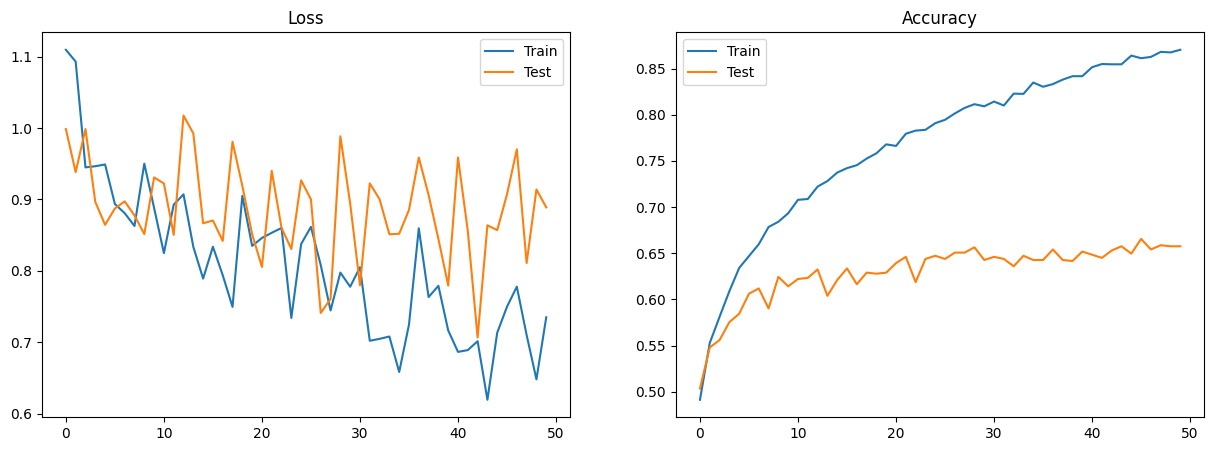

In [278]:
fit(dataloader_train, dataloader_test, model, configs_default['epochs'])

## Treinando um modelo pré-treinado

In [324]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [325]:
# Congelando os pesos da rede
for param in alexnet.parameters():
    param.requires_grad = False

In [327]:
alexnet.classifier[6] = nn.Dropout(0.2)
alexnet.classifier.add_module('7', nn.Linear(4096, 2048))
alexnet.classifier.add_module('8', nn.Linear(2048, 512))
alexnet.classifier.add_module('9', nn.Linear(512, configs_default['num_class']))
alexnet.classifier.add_module('10', nn.LogSoftmax(dim=1))

In [328]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [332]:
# As camadas que inserimos já vem com requires_grad=True
[param for param in alexnet.classifier[8].parameters()][0].requires_grad

True

In [334]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=configs_default['learning_rate'], weight_decay=configs_default['weight_decay'])

Epoch 1 -------------------------------
TRAIN - Loss: 0.7848723649978637 - Acc: 0.6735336194563663
VALIDATE - Loss: 0.7183434615532557 - Acc: 0.684931506849315


Epoch 2 -------------------------------
TRAIN - Loss: 0.6397977398974555 - Acc: 0.7284692417739628
VALIDATE - Loss: 0.6875468475951089 - Acc: 0.708904109589041


Epoch 3 -------------------------------
TRAIN - Loss: 0.631124586718423 - Acc: 0.7353361945636624
VALIDATE - Loss: 0.7011156413290236 - Acc: 0.6986301369863014


Epoch 4 -------------------------------
TRAIN - Loss: 0.6244010665587016 - Acc: 0.7333333333333333
VALIDATE - Loss: 0.6846203174855974 - Acc: 0.723744292237443


Epoch 5 -------------------------------
TRAIN - Loss: 0.5983510298388345 - Acc: 0.7530758226037196
VALIDATE - Loss: 0.6651655154095756 - Acc: 0.7226027397260274


Epoch 6 -------------------------------
TRAIN - Loss: 0.6086332670279911 - Acc: 0.7430615164520744
VALIDATE - Loss: 0.711410770813624 - Acc: 0.6894977168949772


Epoch 7 -------------------

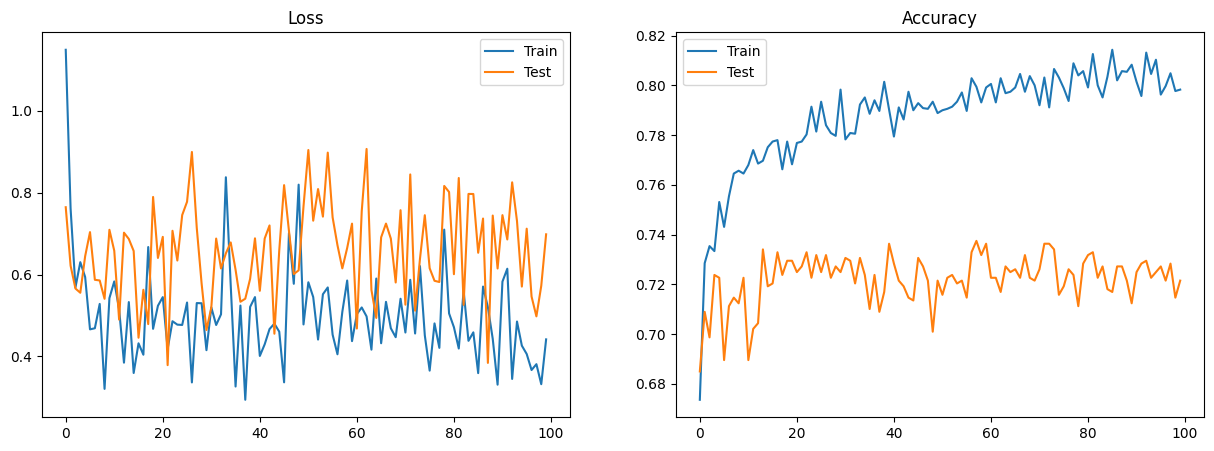

In [335]:
fit(dataloader_train, dataloader_test, alexnet.to(configs_default['device']), configs_default['epochs'])

precision    recall  f1-score   support

         cat       0.69      0.67      0.68       292
         dog       0.75      0.69      0.72       292
       otter       0.74      0.80      0.77       292

    accuracy                           0.72       876
   macro avg       0.72      0.72      0.72       876
weighted avg       0.72      0.72      0.72       876

### Testando outra rede pré-treinada

In [368]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [369]:
# Congelando os pesos da rede
for param in vgg16.parameters():
    param.requires_grad = False

In [370]:
vgg16.classifier[6] = nn.Linear(4096, 2048)
vgg16.classifier.add_module('7', nn.Linear(2048, 512))
vgg16.classifier.add_module('8', nn.Linear(512, configs_default['num_class']))
vgg16.classifier.add_module('9', nn.LogSoftmax(dim=1))

In [371]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=configs_default['learning_rate'], weight_decay=configs_default['weight_decay'])

In [373]:
fit(dataloader_train, dataloader_test, vgg16.to(configs_default['device']), configs_default['epochs'])

Epoch 1 -------------------------------


KeyboardInterrupt: 

# Predição

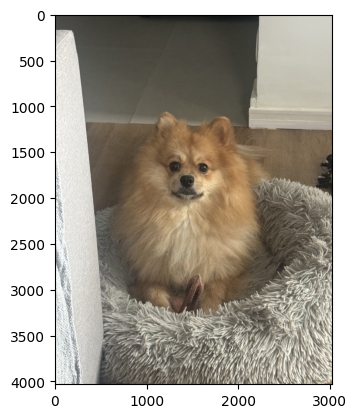

In [374]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

img = cv2.imread('../data/animals_class/dog_test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

img = Image.fromarray(img)
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0).to(configs_default['device'])

In [376]:
with torch.no_grad():
    output = vgg16(img_tensor)
    _, predict = torch.max(output, 1)

print(f"Predict: {label_map[predict.item()]}")

Predict: cat
